# Set up and data preperation

In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import floor

def buildSets(filepath : str, train_size : float, sequence_window : int, xColumns : list, yColumn : str):
    # Read in dataframe 
    df = pd.read_csv(filepath)
    df.sort_values('Date', inplace=True)
    df = df.loc[::-1]

    # Find yColumn index

    # Find full length of dataframe, then use that full length to find the index to cut off for the training set and testing set
    length = len(df)
    trainIndex = floor(length * train_size)

    # Combine columns to 
    fullSet = df[xColumns]

    y_column_index = list(fullSet.columns).index(yColumn)
    
    sc = MinMaxScaler(feature_range=(0,1))
    scaled_set = sc.fit_transform(fullSet)

    sequential_x = []
    sequential_y = []
    for i in range(sequence_window, len(scaled_set)):
        sequential_x.append(scaled_set[i-sequence_window:i, :])
        sequential_y.append(scaled_set[i, y_column_index])

    x, y = np.array(sequential_x), np.array(sequential_y)
    
    x_train, x_test = x[:trainIndex], x[trainIndex:]
    y_train, y_test = y[:trainIndex], y[trainIndex:]

    return x_train, x_test, y_train, y_test, sc    

## Build Model Function

In [2]:
import keras
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

def buildModel(shape,n_neurons):
    model = keras.Sequential()

    model.add(LSTM(units = n_neurons, input_shape = (shape[1],shape[2]), return_sequences=True))
    model.add(Dropout(.2))

    model.add(LSTM(units = n_neurons, return_sequences=True))
    model.add(Dropout(.2))

    model.add(LSTM(units = n_neurons))
    model.add(Dropout(.2))

    model.add(Dense(1, activation='relu'))

    return model

# Training

## Train Bitcoin Model

In [57]:
# Load Data
btc_x_train, btc_x_test, btc_y_train, btc_y_test, btc_sc = buildSets('gemini_BTCUSD_1hr.csv', .8, 24, ['Close','Volume'], 'Close')

# Make callbacks, early stopping and checkpoints
keras_callbacks = [
    EarlyStopping(patience = 10, min_delta = .00001),
    ModelCheckpoint(filepath='bitcoindModelCheckpoint.h5', save_best_only=True)
]

bitcoin_model = buildModel(btc_x_train.shape, 100)

bitcoin_model.compile(optimizer ='adam', loss='mean_squared_error', metrics=['accuracy'])

bitcoin_train_history = bitcoin_model.fit(btc_x_train,btc_y_train, validation_split = .1, batch_size = 32, epochs = 100, callbacks = keras_callbacks)

bitcoin_model.save("bitcoinModel.h5")

Epoch 1/100
1216/1216 [==============================] - 62s 45ms/step - loss: 5.5394e-05 - accuracy: 0.0000e+00 - val_loss: 2.6047e-05 - val_accuracy: 0.0000e+00
Epoch 2/100
1216/1216 [==============================] - 45s 37ms/step - loss: 2.6048e-05 - accuracy: 0.0000e+00 - val_loss: 1.3474e-05 - val_accuracy: 0.0000e+00
Epoch 3/100
1216/1216 [==============================] - 46s 38ms/step - loss: 2.3053e-05 - accuracy: 0.0000e+00 - val_loss: 2.4644e-05 - val_accuracy: 0.0000e+00
Epoch 4/100
1216/1216 [==============================] - 46s 38ms/step - loss: 2.2184e-05 - accuracy: 0.0000e+00 - val_loss: 5.7788e-06 - val_accuracy: 0.0000e+00
Epoch 5/100
1216/1216 [==============================] - 47s 39ms/step - loss: 2.2098e-05 - accuracy: 0.0000e+00 - val_loss: 7.1510e-06 - val_accuracy: 0.0000e+00
Epoch 6/100
1216/1216 [==============================] - 47s 39ms/step - loss: 1.9594e-05 - accuracy: 0.0000e+00 - val_loss: 6.1418e-06 - val_accuracy: 0.0000e+00
Epoch 7/100
1216/1216 

## Train Ethereum Model

In [113]:
eth_x_train, eth_x_test, eth_y_train, eth_y_test, eth_sc = buildSets('gemini_ETHUSD_1hr.csv', .8, 24, ['Volume','Close'], 'Close')

keras_callbacks = [
    EarlyStopping(patience = 10, min_delta = .00001),
    ModelCheckpoint(filepath='ethModelCheckpoint.h5', save_best_only=True)
]

eth_model = buildModel(eth_x_train.shape, 100)

eth_model.compile(optimizer ='adam', loss='mean_squared_error', metrics=['accuracy'])

#eth_train_history = eth_model.fit(eth_x_train,eth_y_train, validation_split = .1, batch_size = 32, epochs = 100, callbacks = keras_callbacks)

#eth_model.save('ethModel.h5')

## Train Litecoin Model

In [115]:
ltc_x_train, ltc_x_test, ltc_y_train, ltc_y_test, ltc_sc = buildSets('gemini_LTCUSD_1hr.csv', .8, 24, ['Volume','Close'], 'Close')

keras_callbacks = [
    EarlyStopping(patience = 10, min_delta = .00001),
    ModelCheckpoint(filepath='ltcModelCheckpoint.h5', save_best_only=True)
]

ltc_model = buildModel(ltc_x_train.shape, 100)

ltc_model.compile(optimizer ='adam', loss='mean_squared_error', metrics=['accuracy'])

#ltc_train_history = ltc_model.fit(ltc_x_train,ltc_y_train, validation_split = .1, batch_size = 32, epochs = 100, callbacks = keras_callbacks)
#ltc_model.save('ltcModel.h5')

In [97]:
bitcoin_model.evaluate(btc_x_test,btc_y_test)
predictions = bitcoin_model.predict(btc_x_test)
count = 0
se = []
for i in range(len(predictions)):
    se.append((btc_y_test[i] - predictions[i])**2)
    if predictions[i] - btc_y_test[i] < .1 * btc_y_test[i]:
        count+=1

print(count)
print(len(btc_y_test))
print(count/len(btc_y_test))
print("MSE:", sum(se)/len(btc_y_test))

337/337 [==============================] - 4s 12ms/step - loss: 0.0017 - accuracy: 9.2782e-05
10778
10778
1.0
MSE: [0.00166621]


# Evaluation

In [116]:
print("Bitcoin model evaluation:")
btc_eval = bitcoin_model.evaluate(btc_x_test, btc_y_test)
print(btc_eval)

print("Ethereum model evaluation:")
eth_eval = eth_model.evaluate(eth_x_test, eth_y_test)
print(eth_eval)

print("Litecoin model evaluation:")
ltc_eval = ltc_model.evaluate(ltc_x_test, ltc_y_test)
print(ltc_eval)

Bitcoin model evaluation:
337/337 [==============================] - 4s 13ms/step - loss: 0.0017 - accuracy: 9.2782e-05
[0.0016662119887769222, 9.278159268433228e-05]
Ethereum model evaluation:
305/305 [==============================] - 4s 14ms/step - loss: 2.3711e-04 - accuracy: 1.0255e-04
[0.00023710797540843487, 0.00010255358210997656]
Litecoin model evaluation:
172/172 [==============================] - 4s 13ms/step - loss: 0.0094 - accuracy: 1.8252e-04
[0.009436746127903461, 0.00018251505389343947]


## Visualize

In [153]:
# Load Data
v_x_train, v_x_test, v_y_train, v_y_test, v_sc = buildSets('gemini_BTCUSD_1hr.csv', .8, 24, ['Close'], 'Close')

# Make callbacks, early stopping and checkpoints
keras_callbacks = [
    EarlyStopping(patience = 10, min_delta = .00001),
    ModelCheckpoint(filepath='visualizeModelCheckpoint.h5', save_best_only=True)
]

v_model = buildModel(v_x_train.shape, 100)

v_model.compile(optimizer ='adam', loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

v_train_history = v_model.fit(v_x_train,v_y_train, validation_split = .1, batch_size = 32, epochs = 100, callbacks = keras_callbacks)

v_model.save("visualizeModel.h5")

Epoch 1/100
1216/1216 [==============================] - 271s 223ms/step - loss: 9.6562e-04 - mean_squared_error: 9.6562e-04 - val_loss: 1.0027e-05 - val_mean_squared_error: 1.0027e-05
Epoch 2/100
1216/1216 [==============================] - 260s 214ms/step - loss: 4.7839e-04 - mean_squared_error: 4.7839e-04 - val_loss: 5.1347e-05 - val_mean_squared_error: 5.1347e-05
Epoch 3/100
1216/1216 [==============================] - 263s 216ms/step - loss: 3.9838e-04 - mean_squared_error: 3.9838e-04 - val_loss: 3.5065e-05 - val_mean_squared_error: 3.5065e-05
Epoch 4/100
1216/1216 [==============================] - 260s 214ms/step - loss: 3.8170e-04 - mean_squared_error: 3.8170e-04 - val_loss: 1.0191e-05 - val_mean_squared_error: 1.0191e-05
Epoch 5/100
1216/1216 [==============================] - 261s 215ms/step - loss: 3.6560e-04 - mean_squared_error: 3.6560e-04 - val_loss: 5.4714e-07 - val_mean_squared_error: 5.4714e-07
Epoch 6/100
1216/1216 [==============================] - 260s 214ms/step - 

In [4]:
import matplotlib.pyplot as plt

btc_model = keras.models.load_model('bitcoinModel.h5')
eth_model = keras.models.load_model('ethModel.h5')
ltc_eval = keras.models.load_model('ltcModel.h5')

btc_full = pd.read_csv('gemini_BTCUSD_1hr.csv')[['Date','Open', 'High', 'Low','Close','Volume']]

#plt.plot_date(btc_full['Date'], btc_full['Close'].values, color = 'red')

#plt.show()



24
1/1 [==============================] - 0s 47ms/step - loss: 0.1129 - mean_squared_error: 0.1129


C:\Users\jd74h\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


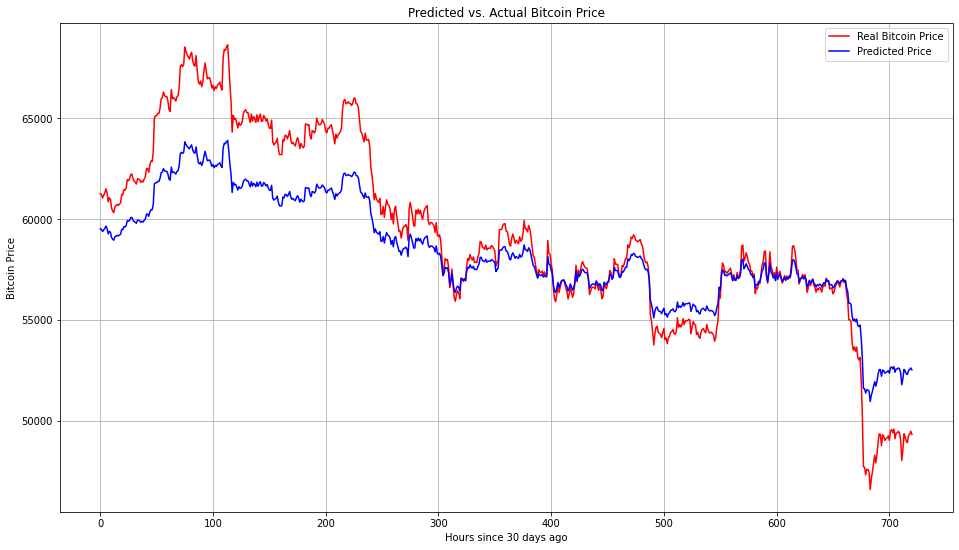

In [159]:
#v_model.evaluate(v_x_test,v_y_test)
#v_model.summary()

test = btc_full
test.sort_values('Date',inplace=True)

predicted = v_model.predict(v_sc.transform(btc_full.loc[23:,['Close']]).reshape(1,24,1)) 

data = v_sc.transform(btc_full.loc[23:,['Close']])

print(len(data))





predictions = v_sc.inverse_transform(v_model.predict(v_sc.transform(btc_full.loc[24*30:,['Close']]))) * 2

v_model.evaluate(v_sc.transform(btc_full.loc[24:1,['Close']]), v_sc.transform(btc_full.loc[23:,['Close']]))

data = v_sc.transform(np.array(btc_full.loc[31*24:30*24,['Close']]).reshape(-1,1))

#temp = []
#
#for i in range(30*24):
#    prediction = v_model.predict(data)
#    np.append(data, prediction)
#    data = data[1:]
#    temp.append(prediction)
#
#print(temp)

plt.figure(figsize=(16,9))
plt.plot(btc_full.loc[30*24:,'Close'].values, color = 'red', label = 'Real Bitcoin Price')

plt.plot(predictions, color = 'blue', label = 'Predicted Price')

plt.xlabel('Hours since 30 days ago')
plt.ylabel("Bitcoin Price")
plt.title("Predicted vs. Actual Bitcoin Price")
plt.legend()
plt.grid(True)
plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


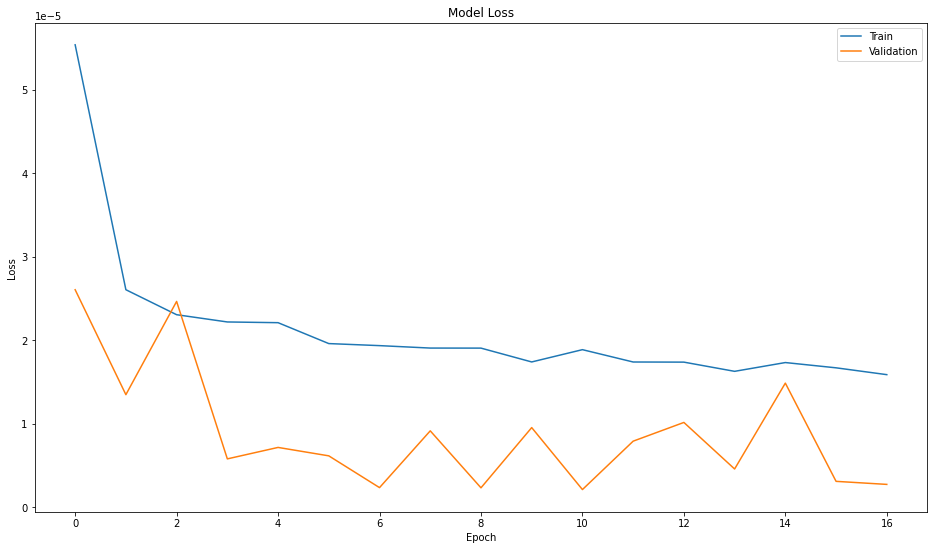

In [67]:
print(bitcoin_train_history.history.keys())

plt.figure(figsize=(16,9))
plt.plot(bitcoin_train_history.history['loss'])
plt.plot(bitcoin_train_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()